"""
═══════════════════════════════════════════════════════════════════════════
NOTEBOOK 2: Task Router Training & Multi-Expert Inference
═══════════════════════════════════════════════════════════════════════════
Train a neural router to automatically select the right LoRA expert
        Prerequisite: Run Notebook 1 first to train LoRA experts
"""

In [11]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 1: Setup & Installation
# ═══════════════════════════════════════════════════════════════════════════

!pip install -q transformers datasets peft accelerate bitsandbytes sentencepiece torch scikit-learn

# Verify GPU
import torch
import torch.nn as nn
print(f" PyTorch version: {torch.__version__}")
print(f" CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f" GPU: {torch.cuda.get_device_name(0)}")

 PyTorch version: 2.8.0+cu126
 CUDA available: True
 GPU: Tesla T4


In [32]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from datasets import load_dataset
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# Import sklearn metrics
try:
    from sklearn.metrics import classification_report, confusion_matrix
    print("✓ sklearn imported successfully")
except ImportError:
    print("⚠ sklearn not found, installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'scikit-learn'])
    from sklearn.metrics import classification_report, confusion_matrix
    print("✓ sklearn installed and imported")

print("✓ All libraries imported successfully!")

✓ sklearn imported successfully
✓ All libraries imported successfully!


In [8]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 3: Load Configuration from Notebook 1
# ═══════════════════════════════════════════════════════════════════════════
import os
import json
# Load the configuration saved by Notebook 1
print("Loading configuration from Notebook 1...")

if not os.path.exists('./experts_config.json'):
    raise FileNotFoundError(
        " Configuration file not found!\n"
        "Please run Notebook 1 first to train LoRA experts."
    )

with open('./experts_config.json', 'r') as f:
    config = json.load(f)

MODEL_NAME = config['model_name']
MAX_LENGTH = config['max_length']
LORA_PATHS = config['lora_paths']
TASKS = config['tasks']

print(" Configuration loaded successfully")
print(f"  Base model: {MODEL_NAME}")
print(f"  Available experts: {list(LORA_PATHS.keys())}")
print(f"  Number of tasks: {len(LORA_PATHS)}")

# Verify all LoRA experts exist
print("\nVerifying LoRA experts...")
for task_name, path in LORA_PATHS.items():
    if os.path.exists(path):
        print(f"   {task_name}: {path}")
    else:
        print(f"   {task_name}: NOT FOUND at {path}")

Loading configuration from Notebook 1...
 Configuration loaded successfully
  Base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Available experts: ['medical', 'code', 'math', 'creative']
  Number of tasks: 4

Verifying LoRA experts...
   medical: ./lora_experts/medical
   code: ./lora_experts/code
   math: ./lora_experts/math
   creative: ./lora_experts/creative


In [12]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 4: Router Configuration
# ═══════════════════════════════════════════════════════════════════════════

# Router training hyperparameters
ROUTER_CONFIG = {
    'hidden_dim': 256,
    'learning_rate': 1e-3,
    'num_epochs': 15,
    'batch_size': 32,
    'samples_per_task': 500,  # Number of samples to use per task for router training
    'validation_split': 0.2
}

print("Router Configuration:")
for key, value in ROUTER_CONFIG.items():
    print(f"  {key}: {value}")


Router Configuration:
  hidden_dim: 256
  learning_rate: 0.001
  num_epochs: 15
  batch_size: 32
  samples_per_task: 500
  validation_split: 0.2


In [23]:
class TaskRouter(nn.Module):
    """Neural router to select appropriate LoRA expert"""
    def __init__(self, input_dim: int, num_tasks: int, hidden_dim: int = 256):
        super().__init__()
        self.router = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, num_tasks)
        )
        self.num_tasks = num_tasks

    def forward(self, embeddings):
        """
        Args:
            embeddings: [batch_size, hidden_dim] - mean-pooled embeddings
        Returns:
            logits: [batch_size, num_tasks]
        """
        logits = self.router(embeddings)
        return logits

print("✓ Router model class defined")

✓ Router model class defined


In [16]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 6: Dataset Classes for Router Training
# ═══════════════════════════════════════════════════════════════════════════
from dataclasses import dataclass
from typing import Optional
from torch.utils.data import Dataset

@dataclass
class TaskConfig:
    """Task configuration for data loading"""
    name: str
    dataset_name: str
    dataset_config: Optional[str]
    prompt_template: str

# Recreate task configs for data loading
TASK_CONFIGS = {
    "medical": TaskConfig(
        name="medical_conversation",
        dataset_name="medalpaca/medical_meadow_medical_flashcards",
        dataset_config=None,
        prompt_template="### Medical Question:\n{input}\n\n### Answer:\n"
    ),
    "code": TaskConfig(
        name="code_generation",
        dataset_name="iamtarun/python_code_instructions_18k_alpaca",
        dataset_config=None,
        prompt_template="### Instruction:\n{input}\n\n### Code:\n"
    ),
    "math": TaskConfig(
        name="math_reasoning",
        dataset_name="gsm8k",
        dataset_config="main",
        prompt_template="### Problem:\n{input}\n\n### Solution:\n"
    ),
    "creative": TaskConfig(
        name="creative_writing",
        dataset_name="euclaise/writingprompts",
        dataset_config=None,
        prompt_template="### Writing Prompt:\n{input}\n\n### Story:\n"
    )
}

class RouterDataset(Dataset):
    """Dataset for router training"""
    def __init__(self, embeddings: torch.Tensor, labels: torch.Tensor):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embedding': self.embeddings[idx],
            'label': self.labels[idx]
        }

print(" Router dataset class defined")

 Router dataset class defined


In [17]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 7: Data Preparation Functions
# ═══════════════════════════════════════════════════════════════════════════

def prepare_task_prompts(task_name: str, num_samples: int = 500):
    """Load prompts for a specific task"""
    config = TASK_CONFIGS[task_name]
    prompts = []

    print(f"  Loading {task_name} data...")

    try:
        if config.dataset_config:
            ds = load_dataset(config.dataset_name, config.dataset_config, split='train')
        else:
            ds = load_dataset(config.dataset_name, split='train')

        for i, item in enumerate(ds):
            if len(prompts) >= num_samples:
                break

            # Extract input text based on task
            if task_name == 'medical':
                input_text = item.get('input', '') or item.get('instruction', '')
            elif task_name == 'code':
                input_text = item.get('instruction', '')
            elif task_name == 'math':
                input_text = item.get('question', '')
            elif task_name == 'creative':
                input_text = item.get('prompt', '')

            if input_text:
                prompt = config.prompt_template.format(input=input_text)
                prompts.append(prompt)

        print(f"     Loaded {len(prompts)} samples")
        return prompts

    except Exception as e:
        print(f"     Failed to load {task_name}: {e}")
        return []

print("Data preparation functions defined")


Data preparation functions defined


In [20]:

# ═══════════════════════════════════════════════════════════════════════════
# CELL 8: Load Tokenizer and Base Model
# ═══════════════════════════════════════════════════════════════════════════
from transformers import AutoTokenizer,AutoModelForCausalLM
print("Loading tokenizer and base model...")
print(f"Model: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

print(" Tokenizer loaded")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
base_model.eval()

print("Base model loaded and ready")
print(f"  Hidden size: {base_model.config.hidden_size}")

Loading tokenizer and base model...
Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

 Tokenizer loaded
Device: cuda


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Base model loaded and ready
  Hidden size: 2048


In [21]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 2: Import Libraries
# ═══════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType
)
from datasets import load_dataset
import json
import os
from dataclasses import dataclass
from typing import Optional, List, Dict
import warnings
warnings.filterwarnings('ignore')

In [24]:

print("\n" + "="*70)
print("EXTRACTING EMBEDDINGS FOR ROUTER TRAINING")
print("="*70)

all_embeddings = []
all_labels = []
task_id_map = {name: idx for idx, name in enumerate(LORA_PATHS.keys())}

print(f"\nTask ID mapping: {task_id_map}")
print("\nNote: Using mean pooling to handle variable-length sequences")

for task_name in LORA_PATHS.keys():
    print(f"\n[{task_id_map[task_name]+1}/{len(LORA_PATHS)}] Processing {task_name}...")

    # Load prompts for this task
    prompts = prepare_task_prompts(task_name, ROUTER_CONFIG['samples_per_task'])

    if not prompts:
        print(f"  ⚠ Skipping {task_name} - no data loaded")
        continue

    # Extract embeddings
    print(f"  Extracting embeddings...")
    task_embeddings = []

    for i in range(0, len(prompts), 8):  # Process in batches of 8
        batch_prompts = prompts[i:i+8]

        # Tokenize
        inputs = tokenizer(
            batch_prompts,
            max_length=MAX_LENGTH,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = base_model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # Last layer [batch, seq_len, hidden_dim]
            attention_mask = inputs['attention_mask']  # [batch, seq_len]

            # Apply mean pooling over sequence length (ignoring padding tokens)
            # Expand attention mask to match hidden_states dimensions
            mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()

            # Sum embeddings and divide by number of non-padding tokens
            sum_embeddings = torch.sum(hidden_states * mask_expanded, dim=1)
            sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
            mean_pooled = sum_embeddings / sum_mask  # [batch, hidden_dim]

            # Store mean-pooled embeddings
            for emb in mean_pooled:
                task_embeddings.append(emb.cpu())

    # Add to collection
    all_embeddings.extend(task_embeddings)
    all_labels.extend([task_id_map[task_name]] * len(task_embeddings))

    print(f"  ✓ Extracted {len(task_embeddings)} mean-pooled embeddings")

# Convert to tensors - now all embeddings have same shape [hidden_dim]
X = torch.stack(all_embeddings)  # [total_samples, hidden_dim]
y = torch.tensor(all_labels, dtype=torch.long)

print("\n" + "="*70)
print("EMBEDDING EXTRACTION COMPLETE")
print("="*70)
print(f"Total samples: {len(X)}")
print(f"Embedding shape: {X.shape}")
print(f"Label distribution:")
for task_name, task_id in task_id_map.items():
    count = (y == task_id).sum().item()
    print(f"  {task_name}: {count} samples")


EXTRACTING EMBEDDINGS FOR ROUTER TRAINING

Task ID mapping: {'medical': 0, 'code': 1, 'math': 2, 'creative': 3}

Note: Using mean pooling to handle variable-length sequences

[1/4] Processing medical...
  Loading medical data...
     Loaded 500 samples
  Extracting embeddings...
  ✓ Extracted 500 mean-pooled embeddings

[2/4] Processing code...
  Loading code data...
     Loaded 500 samples
  Extracting embeddings...
  ✓ Extracted 500 mean-pooled embeddings

[3/4] Processing math...
  Loading math data...
     Loaded 500 samples
  Extracting embeddings...
  ✓ Extracted 500 mean-pooled embeddings

[4/4] Processing creative...
  Loading creative data...
     Loaded 500 samples
  Extracting embeddings...
  ✓ Extracted 500 mean-pooled embeddings

EMBEDDING EXTRACTION COMPLETE
Total samples: 2000
Embedding shape: torch.Size([2000, 2048])
Label distribution:
  medical: 500 samples
  code: 500 samples
  math: 500 samples
  creative: 500 samples


In [26]:

# ═══════════════════════════════════════════════════════════════════════════
# CELL 10: Split Train/Validation Data
# ═══════════════════════════════════════════════════════════════════════════
from torch.utils.data import DataLoader
print("\nSplitting data into train/validation sets...")

# Shuffle indices
indices = torch.randperm(len(X))
train_size = int((1 - ROUTER_CONFIG['validation_split']) * len(X))

train_indices = indices[:train_size]
val_indices = indices[train_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]

print(f"Data split complete")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")

# Create datasets
train_dataset = RouterDataset(X_train, y_train)
val_dataset = RouterDataset(X_val, y_val)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=ROUTER_CONFIG['batch_size'],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=ROUTER_CONFIG['batch_size'],
    shuffle=False
)

print(f" DataLoaders created")



Splitting data into train/validation sets...
Data split complete
  Training samples: 1600
  Validation samples: 400
 DataLoaders created


In [27]:

# ═══════════════════════════════════════════════════════════════════════════
# CELL 11: Initialize Router Model
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("INITIALIZING ROUTER MODEL")
print("="*70)

hidden_dim = base_model.config.hidden_size
num_tasks = len(LORA_PATHS)

router = TaskRouter(
    input_dim=hidden_dim,
    num_tasks=num_tasks,
    hidden_dim=ROUTER_CONFIG['hidden_dim']
).to(device)

# Count parameters
total_params = sum(p.numel() for p in router.parameters())
trainable_params = sum(p.numel() for p in router.parameters() if p.requires_grad)

print(f"  Router initialized")
print(f"  Input dim: {hidden_dim}")
print(f"  Hidden dim: {ROUTER_CONFIG['hidden_dim']}")
print(f"  Output classes: {num_tasks}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


INITIALIZING ROUTER MODEL
  Router initialized
  Input dim: 2048
  Hidden dim: 256
  Output classes: 4
  Total parameters: 557,956
  Trainable parameters: 557,956


In [28]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 12: Train Router
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("TRAINING ROUTER")
print("="*70)

# Setup training
optimizer = torch.optim.AdamW(router.parameters(), lr=ROUTER_CONFIG['learning_rate'])
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=ROUTER_CONFIG['num_epochs']
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

# Training loop
for epoch in range(ROUTER_CONFIG['num_epochs']):
    # Training phase
    router.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        embeddings = batch['embedding'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = router(embeddings)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * len(labels)
        predictions = logits.argmax(dim=1)
        train_correct += (predictions == labels).sum().item()
        train_total += len(labels)

    # Validation phase
    router.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['label'].to(device)

            logits = router(embeddings)
            loss = criterion(logits, labels)

            val_loss += loss.item() * len(labels)
            predictions = logits.argmax(dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += len(labels)

    # Calculate metrics
    train_loss = train_loss / train_total
    train_acc = 100 * train_correct / train_total
    val_loss = val_loss / val_total
    val_acc = 100 * val_correct / val_total

    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{ROUTER_CONFIG['num_epochs']} - "
          f"Loss: {train_loss:.4f} - Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(router.state_dict(), "./router_model_best.pt")
        print(f"   New best model saved (Val Acc: {val_acc:.2f}%)")

    scheduler.step()

# Save final model
torch.save(router.state_dict(), "./router_model_final.pt")

print("\n" + "="*70)
print(" ROUTER TRAINING COMPLETE")
print("="*70)
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Final validation accuracy: {val_acc:.2f}%")


TRAINING ROUTER
Epoch 1/15 - Loss: 0.0761 - Acc: 98.50% - Val Loss: 0.0001 - Val Acc: 100.00%
   New best model saved (Val Acc: 100.00%)
Epoch 2/15 - Loss: 0.0001 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 3/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 4/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 5/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 6/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 7/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 8/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 9/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 10/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 11/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc: 100.00%
Epoch 12/15 - Loss: 0.0000 - Acc: 100.00% - Val Loss: 0.0000 - Val Acc

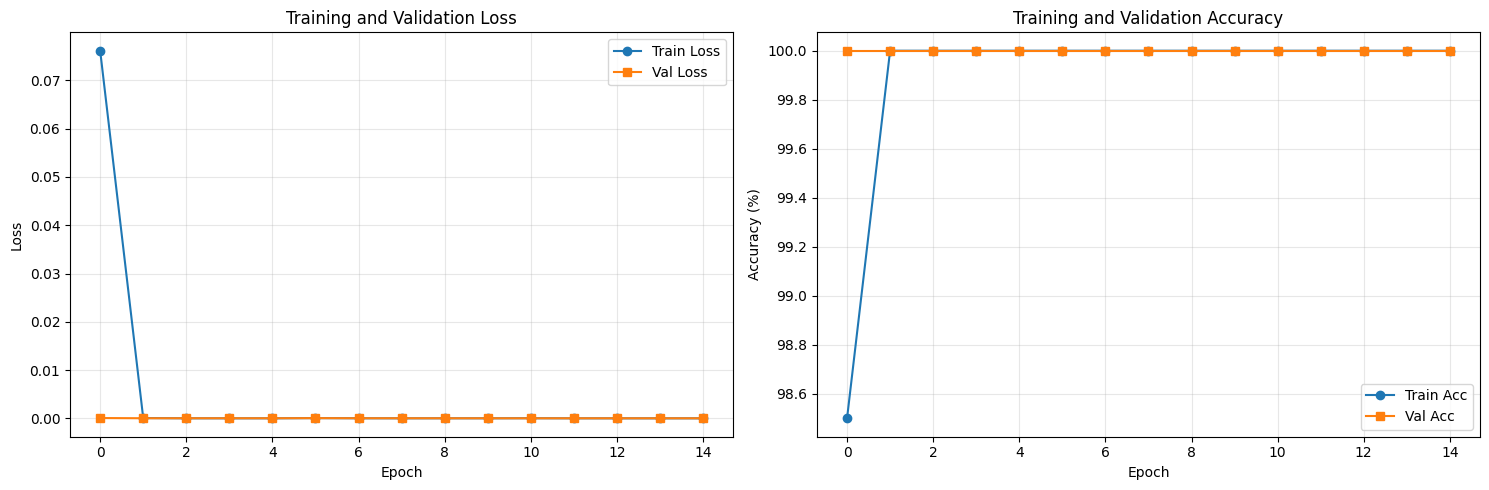

 Training history visualized and saved


In [30]:

import matplotlib.pyplot as plt
# ═══════════════════════════════════════════════════════════════════════════
# CELL 13: Visualize Training History
# ═══════════════════════════════════════════════════════════════════════════

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('router_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Training history visualized and saved")


EVALUATING ROUTER PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

     medical       1.00      1.00      1.00        90
        code       1.00      1.00      1.00        96
        math       1.00      1.00      1.00       110
    creative       1.00      1.00      1.00       104

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



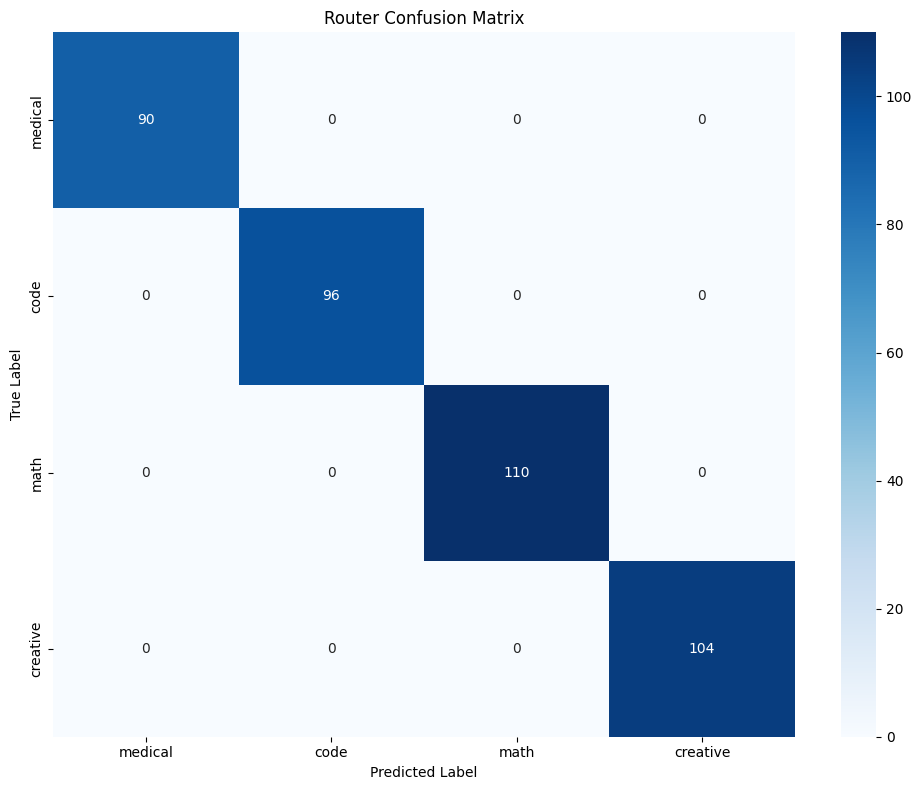

 Evaluation complete


In [33]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 14: Evaluate Router Performance
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("EVALUATING ROUTER PERFORMANCE")
print("="*70)

# Load best model
router.load_state_dict(torch.load("./router_model_best.pt"))
router.eval()

# Get predictions on validation set
all_preds = []
all_true = []

with torch.no_grad():
    for batch in val_loader:
        embeddings = batch['embedding'].to(device)
        labels = batch['label']

        logits = router(embeddings)
        predictions = logits.argmax(dim=1).cpu()

        all_preds.extend(predictions.tolist())
        all_true.extend(labels.tolist())

# Classification report
task_names = list(LORA_PATHS.keys())
print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=task_names))

# Confusion matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=task_names,
            yticklabels=task_names)
plt.title('Router Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('router_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Evaluation complete")


In [34]:

# ═══════════════════════════════════════════════════════════════════════════
# CELL 15: Save Router Configuration
# ═══════════════════════════════════════════════════════════════════════════

router_config = {
    "model_name": MODEL_NAME,
    "hidden_dim": ROUTER_CONFIG['hidden_dim'],
    "num_tasks": num_tasks,
    "task_id_map": task_id_map,
    "task_names": task_names,
    "best_val_acc": best_val_acc,
    "lora_paths": LORA_PATHS
}

with open("./router_config.json", "w") as f:
    json.dump(router_config, f, indent=2)

print(" Router configuration saved to router_config.json")

 Router configuration saved to router_config.json


In [35]:
class MultiLoRAInference:
    """Inference with automatic task routing"""
    def __init__(self, base_model_name: str, lora_paths: Dict[str, str],
                 router_path: str, router_config: dict):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print("="*70)
        print("INITIALIZING MULTI-LORA INFERENCE PIPELINE")
        print("="*70)

        # Load tokenizer
        print("\n1. Loading tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained(base_model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        print("   ✓ Tokenizer loaded")

        # Load base model
        print("\n2. Loading base model...")
        self.base_model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            device_map="auto"
        )
        self.base_model.eval()
        print("   ✓ Base model loaded")

        # Load LoRA adapters
        print("\n3. Loading LoRA experts...")
        self.lora_models = {}
        for task_name, path in lora_paths.items():
            try:
                self.lora_models[task_name] = PeftModel.from_pretrained(
                    self.base_model, path
                )
                print(f"   ✓ {task_name}")
            except Exception as e:
                print(f"   ✗ {task_name}: {e}")

        # Load router
        print("\n4. Loading router...")
        hidden_dim = self.base_model.config.hidden_size
        self.router = TaskRouter(
            hidden_dim,
            router_config['num_tasks'],
            router_config['hidden_dim']
        )
        self.router.load_state_dict(torch.load(router_path))
        self.router.to(self.device)
        self.router.eval()
        print("   ✓ Router loaded")

        self.task_names = router_config['task_names']

        print("\n" + "="*70)
        print("✓ INFERENCE PIPELINE READY!")
        print("="*70)
        print(f"Available experts: {list(self.lora_models.keys())}")

    def route_task(self, prompt: str) -> tuple:
        """Determine which task the prompt belongs to"""
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            max_length=MAX_LENGTH,
            truncation=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            # Get hidden states
            outputs = self.base_model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # [1, seq_len, hidden_dim]
            attention_mask = inputs['attention_mask']  # [1, seq_len]

            # Apply mean pooling
            mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
            sum_embeddings = torch.sum(hidden_states * mask_expanded, dim=1)
            sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
            mean_pooled = sum_embeddings / sum_mask  # [1, hidden_dim]

            # Route
            logits = self.router(mean_pooled)
            probs = torch.softmax(logits, dim=1)
            task_id = logits.argmax(dim=1).item()
            confidence = probs[0, task_id].item()

        return self.task_names[task_id], confidence

    def generate(self, prompt: str, max_new_tokens: int = 200,
                 temperature: float = 0.7, top_p: float = 0.95):
        """Generate response with automatic task routing"""
        # Route to appropriate expert
        task, confidence = self.route_task(prompt)
        print(f"🎯 Routed to: {task} (confidence: {confidence:.1%})")

        # Select model
        if task not in self.lora_models:
            print(f"⚠ Expert '{task}' not available, using base model")
            model = self.base_model
        else:
            model = self.lora_models[task]

        # Generate
        inputs = self.tokenizer(prompt, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                do_sample=True,
                top_p=top_p,
                pad_token_id=self.tokenizer.eos_token_id
            )

        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return response, task, confidence

print("✓ MultiLoRAInference class defined")

✓ MultiLoRAInference class defined


In [36]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 17: Initialize Inference Pipeline
# ═══════════════════════════════════════════════════════════════════════════

# Load router configuration
with open("./router_config.json", "r") as f:
    router_cfg = json.load(f)

# Initialize inference pipeline
inference_pipeline = MultiLoRAInference(
    MODEL_NAME,
    LORA_PATHS,
    "./router_model_best.pt",
    router_cfg
)

print("\n Ready for inference!")

INITIALIZING MULTI-LORA INFERENCE PIPELINE

1. Loading tokenizer...
   ✓ Tokenizer loaded

2. Loading base model...
   ✓ Base model loaded

3. Loading LoRA experts...
   ✗ medical: module 'torch._dynamo.convert_frame' has no attribute 'convert_frame'
   ✗ code: This is not allowed since there's already a kernel registered from python overriding int8_mm_dequant's behavior for CompositeExplicitAutograd dispatch key and bitsandbytes namespace.
   ✗ math: This is not allowed since there's already a kernel registered from python overriding int8_mm_dequant's behavior for CompositeExplicitAutograd dispatch key and bitsandbytes namespace.
   ✗ creative: This is not allowed since there's already a kernel registered from python overriding int8_mm_dequant's behavior for CompositeExplicitAutograd dispatch key and bitsandbytes namespace.

4. Loading router...
   ✓ Router loaded

✓ INFERENCE PIPELINE READY!
Available experts: []

 Ready for inference!


In [37]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 18: Interactive Testing
# ═══════════════════════════════════════════════════════════════════════════

# Test prompts for each task
TEST_PROMPTS = {
    "medical": "### Medical Question:\nWhat are the common symptoms of hypertension?\n\n### Answer:\n",
    "code": "### Instruction:\nWrite a Python function to calculate factorial\n\n### Code:\n",
    "math": "### Problem:\nIf Sarah has 24 apples and gives away 7, how many does she have left?\n\n### Solution:\n",
    "creative": "### Writing Prompt:\nWrite a short story about a time traveler\n\n### Story:\n"
}

print("\n" + "="*70)
print("TESTING MULTI-EXPERT INFERENCE")
print("="*70)

for task_type, prompt in TEST_PROMPTS.items():
    print(f"\n{'─'*70}")
    print(f"TEST: {task_type.upper()}")
    print(f"{'─'*70}")
    print(f" Prompt:\n{prompt[:100]}...")
    print()

    try:
        response, routed_task, confidence = inference_pipeline.generate(
            prompt,
            max_new_tokens=150,
            temperature=0.7
        )
        print(f" Response:\n{response}\n")
    except Exception as e:
        print(f" Error: {e}\n")


TESTING MULTI-EXPERT INFERENCE

──────────────────────────────────────────────────────────────────────
TEST: MEDICAL
──────────────────────────────────────────────────────────────────────
 Prompt:
### Medical Question:
What are the common symptoms of hypertension?

### Answer:
...

🎯 Routed to: medical (confidence: 100.0%)
⚠ Expert 'medical' not available, using base model
 Response:
### Medical Question:
What are the common symptoms of hypertension?

### Answer:
The common symptoms of hypertension are:
1. Headache
2. Nausea
3. Weakness
4. Shortness of breath
5. Dizziness
6. Congestion
7. Sweating
8. Insomnia
9. Muscle pain
10. Thirst
11. Poorly controlled blood pressure
12. Pain in the arms or legs
13. Blurred vision
14. Tender or swollen lymph nodes
15. Heart palpitations
16. Eye pain
17. Feeling of fullness or heaviness in the chest
18. Chest pain


──────────────────────────────────────────────────────────────────────
TEST: CODE
────────────────────────────────────────────────────

In [38]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 19: Custom Prompt Testing
# ═══════════════════════════════════════════════════════════════════════════

def test_custom_prompt(prompt: str, max_tokens: int = 200):
    """Test with a custom prompt"""
    print("\n" + "="*70)
    print("CUSTOM PROMPT TEST")
    print("="*70)
    print(f" Your Prompt:\n{prompt}\n")

    response, task, confidence = inference_pipeline.generate(
        prompt,
        max_new_tokens=max_tokens
    )

    print(f"\n Response:\n{response}")
    print(f"\n Routing Info:")
    print(f"  Task: {task}")
    print(f"  Confidence: {confidence:.1%}")
    print("="*70)

# Example usage - modify as needed:
# test_custom_prompt("### Medical Question:\nWhat causes diabetes?\n\n### Answer:\n")
# test_custom_prompt("### Instruction:\nWrite a function to reverse a list\n\n### Code:\n")

print("\n Use test_custom_prompt(your_prompt) to test with custom prompts!")


 Use test_custom_prompt(your_prompt) to test with custom prompts!


In [39]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 20: Save Complete System
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("SAVING COMPLETE SYSTEM")
print("="*70)

# Save everything needed for deployment
deployment_config = {
    "model_name": MODEL_NAME,
    "lora_paths": LORA_PATHS,
    "router_path": "./router_model_best.pt",
    "router_config": router_cfg,
    "max_length": MAX_LENGTH,
    "task_prompts": TASKS
}

with open("./deployment_config.json", "w") as f:
    json.dump(deployment_config, f, indent=2)

print("\n System configuration saved")
print("\n Complete system files:")
print("  • LoRA experts: ./lora_experts/")
for task in LORA_PATHS.keys():
    print(f"    - {task}/")
print("  • Router model: ./router_model_best.pt")
print("  • Router config: ./router_config.json")
print("  • Deployment config: ./deployment_config.json")
print("  • Training plots: router_training_history.png, router_confusion_matrix.png")

print("\n" + "="*70)
print(" COMPLETE SYSTEM READY FOR DEPLOYMENT! ")
print("="*70)


SAVING COMPLETE SYSTEM

 System configuration saved

 Complete system files:
  • LoRA experts: ./lora_experts/
    - medical/
    - code/
    - math/
    - creative/
  • Router model: ./router_model_best.pt
  • Router config: ./router_config.json
  • Deployment config: ./deployment_config.json
  • Training plots: router_training_history.png, router_confusion_matrix.png

 COMPLETE SYSTEM READY FOR DEPLOYMENT! 


In [40]:


# ═══════════════════════════════════════════════════════════════════════════
# CELL 21: Download All Files (Optional)
# ═══════════════════════════════════════════════════════════════════════════

# Uncomment to download complete system to your local machine

from google.colab import files
import shutil
#
print("Creating archives...")
#
# # Archive LoRA experts
shutil.make_archive('lora_experts_complete', 'zip', './lora_experts')
#
# # Download files
print("\nDownloading files...")
files.download('lora_experts_complete.zip')
files.download('router_model_best.pt')
files.download('router_config.json')
files.download('deployment_config.json')
files.download('router_training_history.png')
files.download('router_confusion_matrix.png')
#
print(" Download complete!")

print("\n Tip: Uncomment Cell 21 to download all files to your computer!")

Creating archives...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Download complete!

 Tip: Uncomment Cell 21 to download all files to your computer!
